<a href="https://colab.research.google.com/github/ssv273/NN_intro/blob/master/HW_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import json
with open('/content/kaggle.json', 'r', encoding='utf-8') as fh:
    data = json.load(fh)

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = data['username']
os.environ['KAGGLE_KEY'] = data['key']
!kaggle competitions download -c dogs-vs-cats

train.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!mkdir /content/competitions
!mkdir /content/competitions/dogs-vs-cats

mkdir: cannot create directory ‘/content/competitions’: File exists
mkdir: cannot create directory ‘/content/competitions/dogs-vs-cats’: File exists


In [5]:
!unzip test1.zip -d /content/competitions/dogs-vs-cats

Archive:  test1.zip
replace /content/competitions/dogs-vs-cats/test1/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
!unzip train.zip -d /content/competitions/dogs-vs-cats

Archive:  train.zip
replace /content/competitions/dogs-vs-cats/train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Import Libraries

In [0]:
import matplotlib.pyplot as plt
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import applications
import os
import random
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Looking at pictures

In [0]:
filenames = os.listdir("/content/competitions/dogs-vs-cats/train")

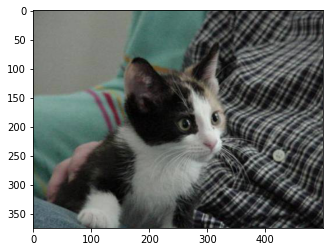

In [9]:
sample = random.choice(filenames)
image = load_img("/content/competitions/dogs-vs-cats/train/"+sample)
plt.imshow(image);

In [10]:
for i in range(10):
  sample = random.choice(filenames)  
  im = Image.open("/content/competitions/dogs-vs-cats/train/"+sample)
  print(im.size)

(500, 373)
(279, 499)
(399, 300)
(350, 465)
(411, 499)
(500, 354)
(440, 459)
(374, 500)
(499, 369)
(499, 500)


Как мы видим - изображения имеют разный размер. Поэтому зададим им размер 128х128

# Constants

In [0]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size = 1024

# Preparing dataset

In [0]:
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})



In [13]:
df.head()

,filename,category
0,cat.174.jpg,0
1,cat.2762.jpg,0
2,dog.6049.jpg,1
3,cat.11772.jpg,0
4,cat.6427.jpg,0


Посмотрим на распределение классов

1    12500
0    12500
Name: category, dtype: int64


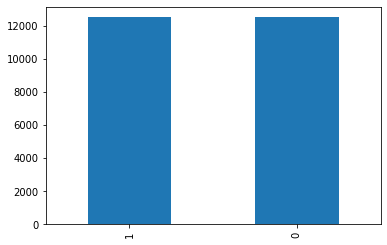

In [14]:
print(df['category'].value_counts())
df['category'].value_counts().plot.bar();

Как мы видим классы сбалансированы

In [0]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

# Train test split

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

# Building model InceptionResNetV2

In [0]:
base_model = applications.inception_resnet_v2.InceptionResNetV2(include_top=False,
                                                                weights='imagenet',
                                                                input_tensor=None, 
                                                                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS ))

In [0]:
# base_model.summary()

# ImageDataGenerator

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/competitions/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/competitions/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


Look at generator`s working results

In [22]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/competitions/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


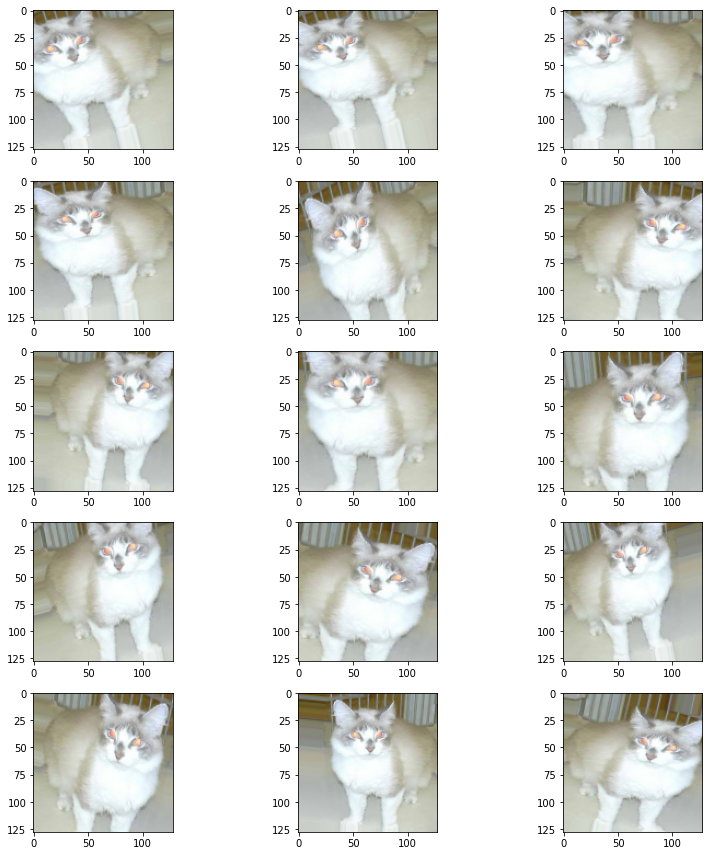

In [23]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Building own model

In [24]:

# Замораживаем сеть InceptionResNetV2
base_model.trainable = False

models = Sequential()
# Добавляем в модель сеть InceptionResNetV2 вместо слоя
models.add(base_model) # только свертка
models.add(BatchNormalization())
models.add(Flatten()) # векторим вход
models.add(Dense(100,activation='relu'))
models.add(Dense(2,activation='softmax'))


models.summary()


print(models.layers[-1].input_shape)

print(models.layers[-1].output_shape)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 2, 2, 1536)        54336736  
_________________________________________________________________
batch_normalization_203 (Bat (None, 2, 2, 1536)        6144      
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               614500    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 54,957,582
Trainable params: 617,774
Non-trainable params: 54,339,808
_________________________________________________________________
(None, 100)
(None, 2)


In [0]:
models.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Callbacks

In [0]:
earlystop = EarlyStopping(patience=10)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
callbacks = [earlystop, learning_rate_reduction]

# Fit model

In [29]:
epochs=5
history = models.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    # callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 9 steps
Epoch 1/5
39/39 [==============================] - 161s 4s/step - loss: 1.1603 - accuracy: 0.7494 - val_loss: 2.2546 - val_accuracy: 0.9264
Epoch 2/5
39/39 [==============================] - 145s 4s/step - loss: 0.6100 - accuracy: 0.7939 - val_loss: 2.3338 - val_accuracy: 0.9314
Epoch 3/5
39/39 [==============================] - 144s 4s/step - loss: 0.4716 - accuracy: 0.8083 - val_loss: 2.4462 - val_accuracy: 0.9303
Epoch 4/5
39/39 [==============================] - 144s 4s/step - loss: 0.4282 - accuracy: 0.8151 - val_loss: 3.3838 - val_accuracy: 0.9147
Epoch 5/5
39/39 [==============================] - 144s 4s/step - loss: 0.4165 - accuracy: 0.8212 - val_loss: 1.8093 - val_accuracy: 0.9358


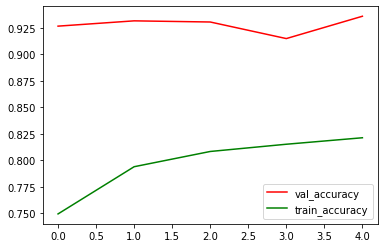

In [30]:
plt.plot(history.history['val_accuracy'],'r',label='val_accuracy')
plt.plot(history.history['accuracy'],'g',label='train_accuracy')
plt.legend()
plt.show()

# Fit model without freezing weights

In [34]:

# Замораживаем сеть InceptionResNetV2
# base_model.trainable = False

model1 = Sequential()
# Добавляем в модель сеть InceptionResNetV2 вместо слоя
model1.add(base_model) # только свертка
model1.add(BatchNormalization())
model1.add(Flatten()) # векторим вход
model1.add(Dense(100,activation='relu'))
model1.add(Dense(2,activation='softmax'))


model1.summary()


print(model1.layers[-1].input_shape)

print(model1.layers[-1].output_shape)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 2, 2, 1536)        54336736  
_________________________________________________________________
batch_normalization_205 (Bat (None, 2, 2, 1536)        6144      
_________________________________________________________________
flatten_2 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               614500    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 54,957,582
Trainable params: 617,774
Non-trainable params: 54,339,808
_________________________________________________________________
(None, 100)
(None, 2)


In [0]:
model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [42]:
epochs=25
history1 = model1.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[earlystop]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 4 steps
Epoch 1/25
19/19 [==============================] - 81s 4s/step - loss: 0.3965 - accuracy: 0.8312 - val_loss: 1.7445 - val_accuracy: 0.9282
Epoch 2/25
19/19 [==============================] - 78s 4s/step - loss: 0.3567 - accuracy: 0.8349 - val_loss: 1.1844 - val_accuracy: 0.9248
Epoch 3/25
19/19 [==============================] - 84s 4s/step - loss: 0.3457 - accuracy: 0.8407 - val_loss: 1.1370 - val_accuracy: 0.9331
Epoch 4/25
19/19 [==============================] - 78s 4s/step - loss: 0.3634 - accuracy: 0.8434 - val_loss: 1.0880 - val_accuracy: 0.9365
Epoch 5/25
19/19 [==============================] - 76s 4s/step - loss: 0.3329 - accuracy: 0.8503 - val_loss: 1.2561 - val_accuracy: 0.9302
Epoch 6/25
19/19 [==============================] - 78s 4s/step - loss: 0.3511 - accuracy: 0.8465 - val_loss: 1.1404 - val_accuracy: 0.9438
Epoch 7/25
19/19 [==============================] - 73s 4s/step - los

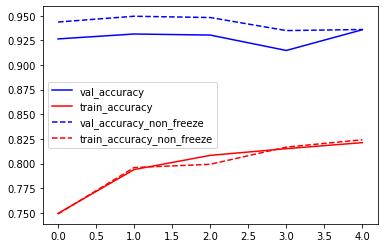

In [37]:
plt.plot(history.history['val_accuracy'], 'b', label='val_accuracy')
plt.plot(history.history['accuracy'], 'r', label='train_accuracy')
plt.plot(history1.history['val_accuracy'], 'b--',label='val_accuracy_non_freeze')
plt.plot(history1.history['accuracy'], 'r--',label='train_accuracy_non_freeze')
plt.legend()


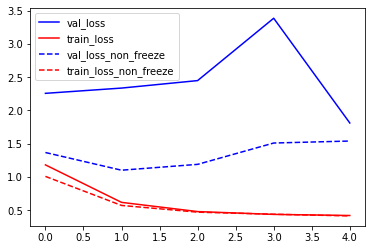

In [38]:
plt.plot(history.history['val_loss'], 'b', label='val_loss')
plt.plot(history.history['loss'], 'r', label='train_loss')
plt.plot(history1.history['val_loss'], 'b--',label='val_loss_non_freeze')
plt.plot(history1.history['loss'], 'r--',label='train_loss_non_freeze')
plt.legend()


Как мы видим нет принципиальной разницы замораживать веса или нет. По времени - одинаковое выполнение, едмнственное отличие, что лосс с незамороженными весами имеет более плавную форму. Точность при обоих эспериментах эквивалентная

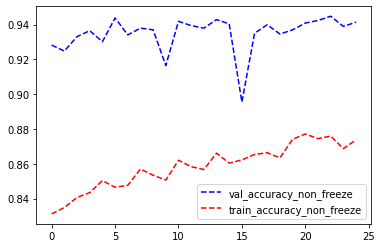

In [45]:
# plt.plot(history.history['val_accuracy'], 'b', label='val_accuracy')
# plt.plot(history.history['accuracy'], 'r', label='train_accuracy')
plt.plot(history1.history['val_accuracy'], 'b--',label='val_accuracy_non_freeze')
plt.plot(history1.history['accuracy'], 'r--',label='train_accuracy_non_freeze')
plt.legend()


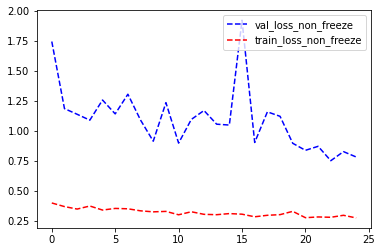

In [46]:
# plt.plot(history.history['val_loss'], 'b', label='val_loss')
# plt.plot(history.history['loss'], 'r', label='train_loss')
plt.plot(history1.history['val_loss'], 'b--',label='val_loss_non_freeze')
plt.plot(history1.history['loss'], 'r--',label='train_loss_non_freeze')
plt.legend()
